In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [2]:
from pna.quad import composite_trapezium

%psource composite_trapezium

def composite_trapezium(f, a, b, n):
    x = np.linspace(a, b, n)
    y = f(x)
    h = (b - a)/n
    return (h/2) * (y[0] + 2*np.sum(y[1:-1]) + y[-1])


In [6]:
from pna.quad import guass_legendre

%psource guass_legendre

def guass_legendre(f, a, b, n):
    beta = 0.5 / np.sqrt(1 - (2 * np.arange(1, n + 1, dtype=float)) ** (-2))
    T = scipy.sparse.diags([beta, beta], [1, -1]).toarray()
    w, v = np.linalg.eig(T)
    i = np.argsort(w)
    return (b-a) * v[0, i] ** 2 @ f(0.5*(b-a)*w[i] + 0.5*(b+a))


In [8]:
from pna.quad import clenshaw_curtis

%psource clenshaw_curtis

def clenshaw_curtis(f, a, b, n):
    #  Chebyshev points
    x = np.cos(np.pi * np.arange(0, n + 1) / n)
    # f evaluated at these points
    fx = f(0.5*(b-a)*x + 0.5*(b+a)) / (2 * n)
    g = np.real(np.fft.fft(np.concatenate([fx, fx[-2:0:-1]])))
    # Chebyshev coefficients
    a = np.concatenate([[g[0]], g[1 : n - 1] + g[-1 : n + 1 : -1], [g[-1]]])
    # weight vector
    w = np.zeros_like(a)
    w[::2] = 2 / (1 - np.arange(0, n, 2) ** 2)
    return 0.5 * (b - a) * w @ a


/tmp/ipykernel_27908/3464098297.py:13: RuntimeWarning: invalid value encountered in power
  (lambda x: x ** (3 / 2), (0, 1), 0.4),


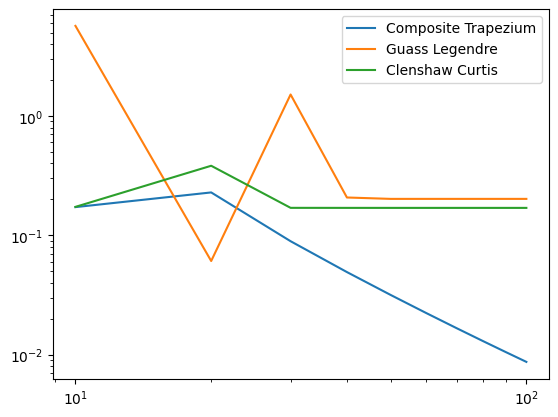

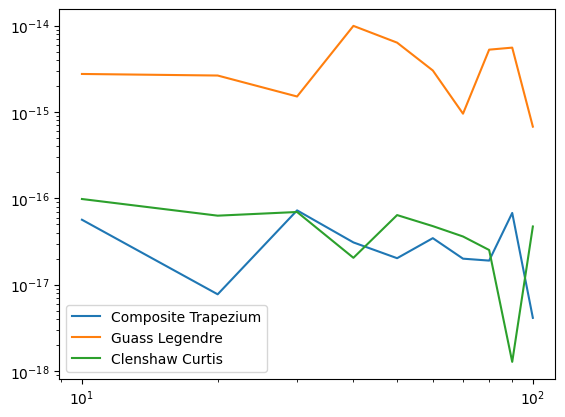

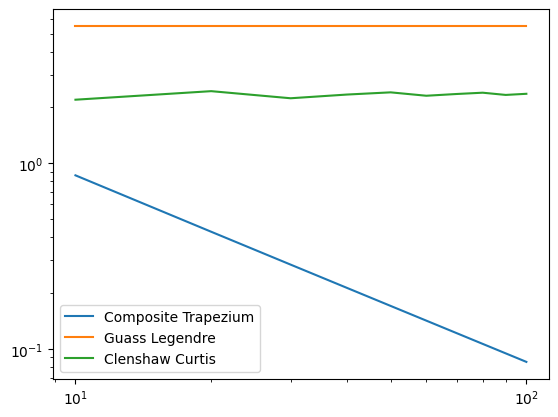

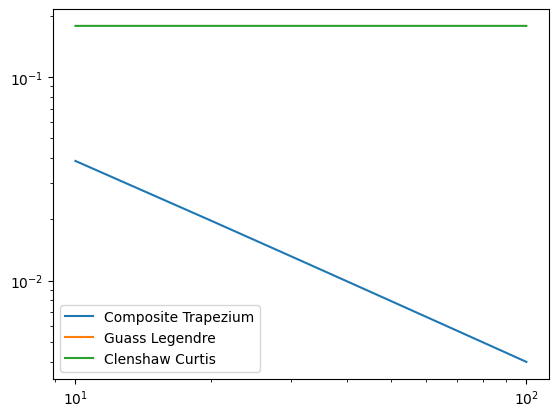

In [10]:
integrals = [
    (
        lambda x: 4 * np.pi * x * np.sin(20 * np.pi * x) * np.cos(2 * np.pi * x),
        (0, 1),
        -20 / 99,
    ),
    (lambda x: np.sin(2 * np.pi * x) * np.cos(4 * np.pi * x), (0, 1), 0),
    (
        lambda x: np.where(x < 1, x + 1, np.where((1 <= x) & (x <= 3), 3 - x, 2)),
        (0, 5),
        7.5,
    ),
    (lambda x: x ** (3 / 2), (0, 1), 0.4),
]

for integrand, interval, exact in integrals:
    composite_trapezium_error = []
    guass_legendre_error = []
    clenshaw_curtis_error = []

    n = np.arange(10, 101, 10)
    for n_i in n:
        err = np.abs(composite_trapezium(integrand, *interval, n_i) - exact)
        composite_trapezium_error.append(err)

        err = np.abs(guass_legendre(integrand, *interval, n_i) - exact)
        guass_legendre_error.append(err)

        err = np.abs(clenshaw_curtis(integrand, *interval, n_i) - exact)
        clenshaw_curtis_error.append(err)

    fig, ax = plt.subplots()
    ax.loglog(n, composite_trapezium_error, label="Composite Trapezium")
    ax.loglog(n, guass_legendre_error, label="Guass Legendre")
    ax.loglog(n, clenshaw_curtis_error, label="Clenshaw Curtis")
    ax.legend()

# Question 2

# Question 3

First we define functions for the four methods.

In [2]:
from pna.root import bisect, regula_falsi, illinois, newton_raphson

%psource bisect

666.6666666666684
-1333.3333333333335


def bisect(f, a, b, tol):
    count = 0
    f_c = math.inf
    while abs(f_c) > tol:
        count += 1
        c = 0.5 * (a + b)
        f_c = f(c)
        if f_c == 0:
            break
        elif f(a) * f(c) < 0:
            b = c
        else:
            a = c
    return c, count


In [3]:
%psource regula_falsi

def regula_falsi(f, a, b, tol):
    count = 0
    f_c = math.inf
    while abs(f_c) > tol:
        f_a = f(a)
        f_b = f(b)
        c = (a * f_b - b * f_a) / (f_b - f_a)
        f_c = f(c)
        count += 1
        if f_c == 0:
            break
        elif f_a * f_c < 0:
            b = c
        else:
            a = c
    return c, count


In [4]:
%psource illinois

def illinois(f, a, b, tol):
    count = 0
    right = True
    count = 0
    f_c = math.inf
    while abs(f_c) > tol:
        f_a = f(a)
        f_b = f(b)
        if count > 1:
            if right:
                f_b /= 2
            else:
                f_a /= 2
        c = (a * f_b - b * f_a) / (f_b - f_a)
        f_c = f(c)
        count += 1
        if f_c == 0:
            break
        elif f_a * f(c) < 0:
            b = c
            if right:
                right_count = 0
            else:
                count += 1
            right = False
        else:
            a = c
            if not right:
                count = 0
            else:
                count += 1
            right = True
    return c, count


In [5]:
%psource newton_raphson

def newton_raphson(f, f_prime, x0, tol):
    k = 0
    x = x0
    while abs(f(x)) > tol:
        x -= f(x) / f_prime(x)
        k += 1
    return x, k


The plot $f(x)$ over the interval $[0,4]$ to determine valid brackets of the roots.

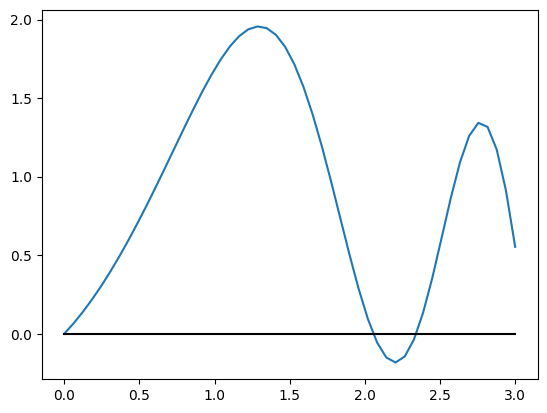

In [6]:
f = lambda x: np.sin(x) + np.sin(x**2)

x = np.linspace(0, 3)

fig, ax = plt.subplots()
ax.plot(x, f(x))
ax.plot([0, 3], [0, 0], "k")

We see that there are three roots bracketed by $[-0.25, 0.25]$, $[2, 2.2]$ and $[2.2, 2.5]$. Using this we can calculate the roots using each of the methods.

In [10]:
f_prime = lambda x: np.cos(x) + 2 * x * np.cos(x**2)

brackets = [(-0.25, 0.25), (1.8, 2.2), (2.2, 2.5)]
tol = 1e-9

for i, bracket in enumerate(brackets):
    print(f"\n\nRoot {i+1}, bracketed by {bracket}")

    x_star, iterations = bisect(f, *bracket, tol)
    print(f"Bisection: {x_star=}, {iterations=}")
    x_star, iterations = regula_falsi(f, *bracket, tol)
    print(f"Regula Falsi: {x_star=}, {iterations=}")
    x_star, iterations = illinois(f, *bracket, tol)
    print(f"Illinois: {x_star=}, {iterations=}")
    x_star, iterations = newton_raphson(f, f_prime, bracket[0], tol)
    print(f"Newton Raphson: {x_star=}, {iterations=}")



Root 1, bracketed by (-0.25, 0.25)
Bisection: x_star=0.0, iterations=1
Regula Falsi: x_star=-9.537843679676623e-10, iterations=12
Illinois: x_star=-4.727872667557848e-16, iterations=2
Newton Raphson: x_star=2.7033771063321343e-15, iterations=5


Root 2, bracketed by (1.8, 2.2)
Bisection: x_star=2.0560096457600587, iterations=28
Regula Falsi: x_star=2.0560096455363697, iterations=18
Illinois: x_star=2.0560096457619434, iterations=1
Newton Raphson: x_star=2.0560096452469483, iterations=4


Root 3, bracketed by (2.2, 2.5)
Bisection: x_star=2.3416277181357144, iterations=28
Regula Falsi: x_star=2.3416277183608094, iterations=17
Illinois: x_star=2.341627718511478, iterations=2
Newton Raphson: x_star=-4.216052223582135, iterations=4


Interestingly, we see for the final root our initial starting point for Newton Raphson didn't lead us to the correct root. This shows one of the limitations of Newton Raphson: you cannot guarantee you will converge to the root you were expecting.

To get a better idea of the convergence of each method we can choose one root and look at how many iterations are required to satisfy an increasingly stringent tolerance.

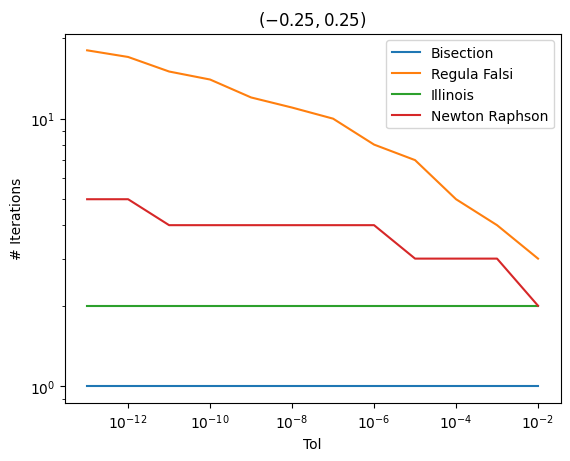

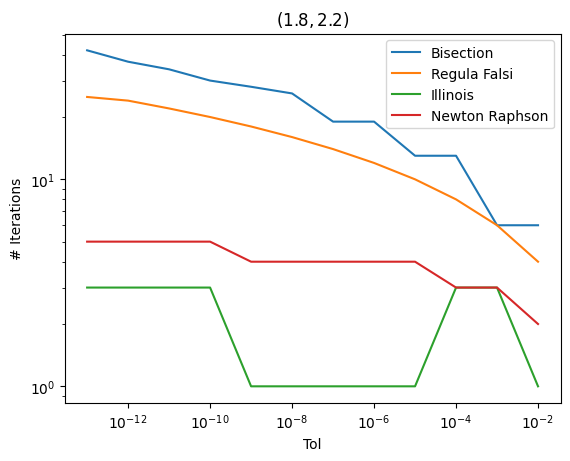

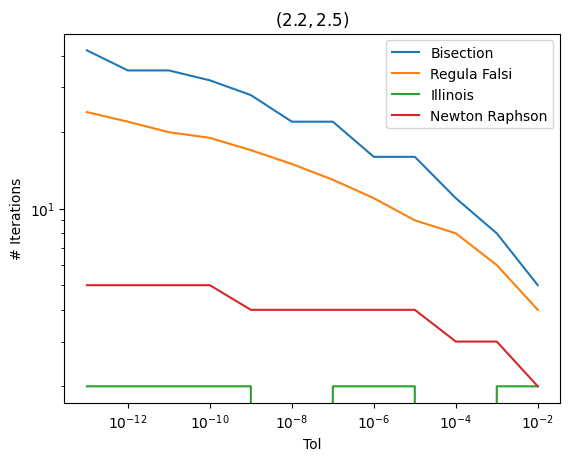

In [8]:
tols = np.logspace(-2, -13, 12)

for bracket in brackets:
    bisect_iter = []
    regula_falsi_iter = []
    illinois_iter = []
    newton_raphson_iter = []
    for tol in tols:
        bisect_iter.append(bisect(f, *bracket, tol)[1])
        regula_falsi_iter.append(regula_falsi(f, *bracket, tol)[1])
        illinois_iter.append(illinois(f, *bracket, tol)[1])
        newton_raphson_iter.append(newton_raphson(f, f_prime, bracket[1], tol)[1])

    fig, ax = plt.subplots()
    ax.loglog(tols, bisect_iter, label="Bisection")
    ax.loglog(tols, regula_falsi_iter, label="Regula Falsi")
    ax.loglog(tols, illinois_iter, label="Illinois")
    ax.loglog(tols, newton_raphson_iter, label="Newton Raphson")
    ax.legend()
    ax.set_xlabel("Tol")
    ax.set_ylabel("# Iterations")
    ax.set_title(f"${bracket}$")

In general, here we see that Illinois coverges fastest followed by Newton Raphson, Regula Falsi and Bisection. The exception is the first root $x=0$ where the provided bracket is symetrical about the root so the bisection method converges exactly in the first iteration.

# Question 4

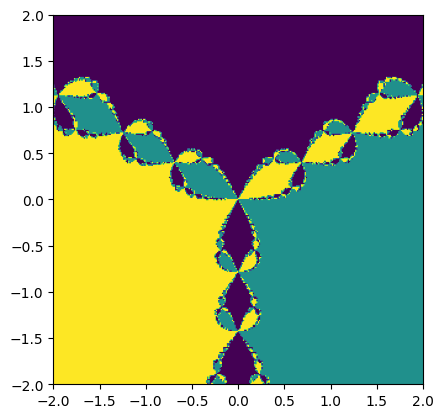

In [4]:
f = lambda z: z**3 - 1
f_prime = lambda z: 3 * z**2

x = np.linspace(-2, 2, 300)
y = np.linspace(-2, 2, 300)

im = np.zeros((len(x), len(y)))

for i, xi in enumerate(x):
    for j, yi in enumerate(y):
        root, _ = newton_raphson(f, f_prime, x0=complex(xi, yi), tol=1e-12)

        if np.isclose(root, 1):
            im[i, j] = 1
        elif np.isclose(root, complex(-0.5, np.sqrt(3) / 2)):
            im[i, j] = 2
        else:
            im[i, j] = 3

fig, ax = plt.subplots()
ax.imshow(im, origin="lower", extent=[-2, 2, -2, 2])
ax.set_aspect("equal")